<a href="https://colab.research.google.com/github/adityaraghavan98/SHAP_tutorial/blob/main/03_SHAP_Spatial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part 3 — SHAP with Spatial Patterns

In this notebook we move beyond tabular toy data and work with a **2D spatial field**.
We will:

- build a simple synthetic spatial dataset (a Gaussian bump + sinusoidal variation),
- fit a regression model,
- visualize SHAP values both as standard plots and as **spatial maps**, and


In [1]:
# Ensure utils.py is available (download from GitHub if missing)
import os

if not os.path.exists("utils.py"):
    !wget -O utils.py https://raw.githubusercontent.com/adityaraghavan98/SHAP_tutorial/main/utils.py



--2025-11-30 08:45:33--  https://raw.githubusercontent.com/adityaraghavan98/SHAP_tutorial/main/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 32345 (32K) [text/plain]
Saving to: ‘utils.py’

utils.py            100%[===================>]  31.59K  --.-KB/s    in 0s      

2025-11-30 08:45:33 (92.5 MB/s) - ‘utils.py’ saved [32345/32345]



In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

import shap

shap.initjs()

plt.rcParams["figure.dpi"] = 120

# Utilities for advanced multi-channel spatial data
from utils import make_spatial_mixed

## 1. Generate a simple spatial dataset

We create a 2D grid of coordinates \((x, y)\) and define a target field:

- a **Gaussian bump** centered at (0, 0),
- plus a **sinusoidal** variation along the x–axis,
- plus a small amount of Gaussian noise.

This mimics a smooth spatial signal that could represent, for example,
a physical property measured on a surface.


In [3]:
# Grid size (try changing nx, ny later in the notebook)
nx, ny = 25, 25

xs = np.linspace(-3, 3, nx)
ys = np.linspace(-3, 3, ny)

X_coords = []
y_vals = []

for x in xs:
    for y in ys:
        bump = 2.0 * np.exp(-0.5 * (x**2 + y**2))   # Gaussian bump
        sinus = 0.5 * np.sin(2.0 * x)               # sinusoidal along x
        noise = 0.15 * np.random.randn()            # small noise
        val = bump + sinus + noise
        X_coords.append((x, y))
        y_vals.append(val)

X = pd.DataFrame(X_coords, columns=["x", "y"])
y = pd.Series(y_vals, name="response")

X.shape, y.shape


((625, 2), (625,))

### Visualizing the spatial field

We can reshape the 1D vector of target values back to a 2D grid
to see the spatial pattern we created.


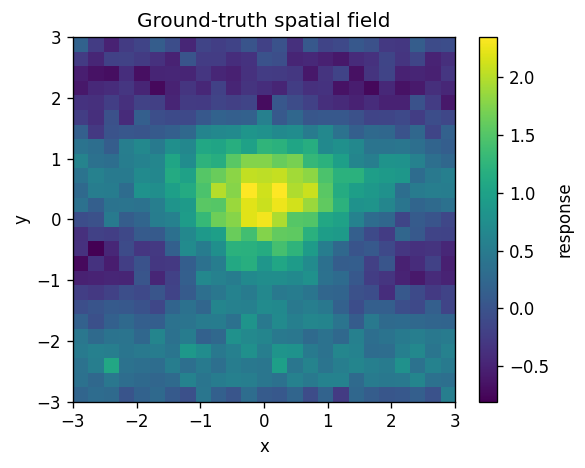

In [4]:
Z = y.values.reshape(ny, nx)

plt.figure(figsize=(5, 4))
im = plt.imshow(Z, origin="lower",
                extent=[xs.min(), xs.max(), ys.min(), ys.max()],
                aspect="auto", cmap="viridis")
plt.colorbar(im, label="response")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Ground-truth spatial field")
plt.tight_layout()
plt.show()


### Interpretation

This heatmap shows the ground-truth spatial pattern the model will learn.  
The bright region in the center comes from the Gaussian bump, and the small
horizontal variations come from the sinusoidal term. SHAP should later recover
these patterns if the model learns them well.


## 2. Fit a regression model

To keep things simple and fast, we use a **Random Forest Regressor**.
It can learn nonlinear relationships and interactions between `x` and `y`.

We split off a small test set for evaluation.


In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0
)

rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=None,
    random_state=0,
    n_jobs=-1,
)
rf.fit(X_train, y_train)

print("Train R^2:", rf.score(X_train, y_train))
print("Test  R^2:", rf.score(X_test, y_test))


Train R^2: 0.9878042233098173
Test  R^2: 0.9148688026721057


## 3. SHAP values for the spatial model

We now compute SHAP values for the Random Forest. For a 2D input like this:

- each grid point is one sample,
- each feature (`x` and `y`) gets a SHAP value for every sample,
- we can reshape those SHAP values back to a 2D grid and visualize them as maps.

This lets us see **where in space** each feature is important.


In [14]:
# Use a subset of training data as background for TreeExplainer
background = X_train.sample(200, random_state=1)

explainer = shap.TreeExplainer(rf, data=background)
shap_values = explainer(X)   # SHAP for all grid points

shap_values;

 97%|=================== | 606/625 [00:25<00:00]       

### Global SHAP summary

First, we look at the standard SHAP summary plot to see which features
(`x` or `y`) are most important overall.


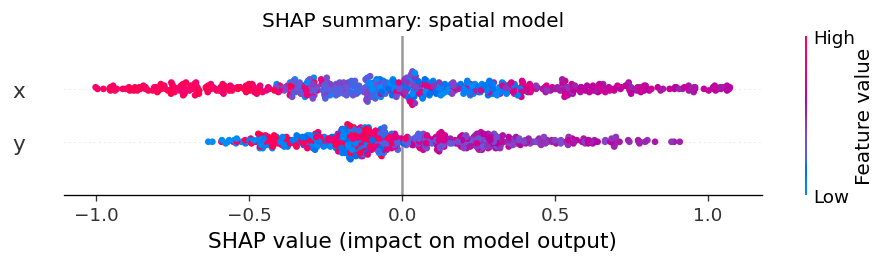

In [7]:
shap.plots.beeswarm(shap_values, show=False)
plt.title("SHAP summary: spatial model")
plt.tight_layout()
plt.show()


### Spatial SHAP maps

We can also reshape the SHAP values for each feature back onto the 2D grid
to see where each feature is contributing positively or negatively.

- Positive SHAP values (yellow/red) mean that feature value at that point
  **pushes the prediction up**.
- Negative SHAP values (blue) mean it **pushes the prediction down**.


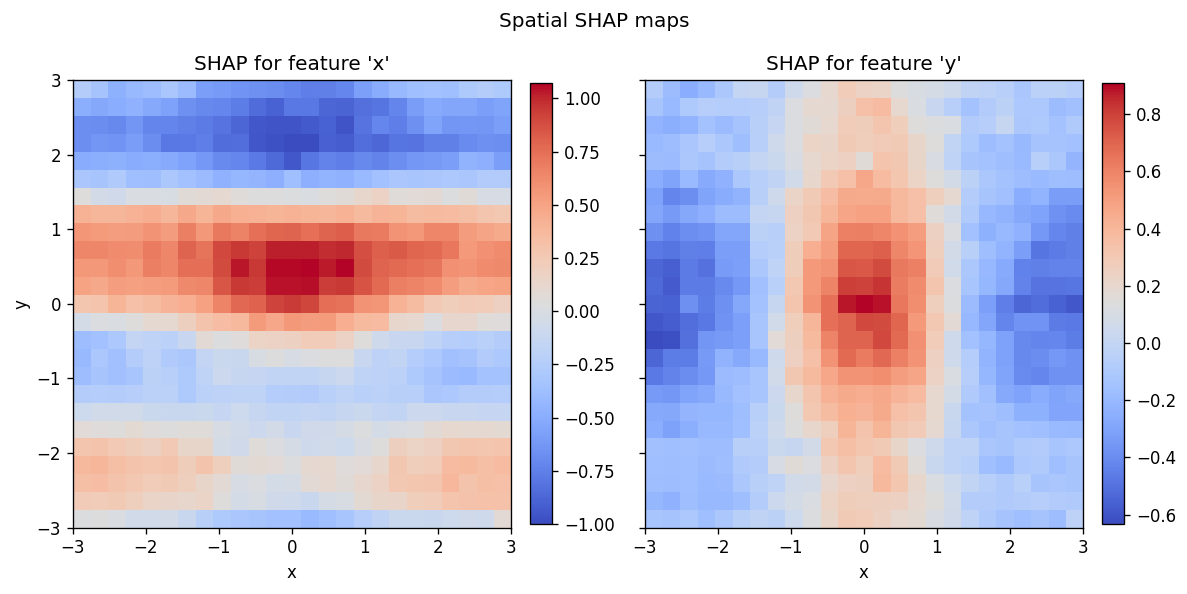

In [13]:
# Extract SHAP values for each feature and reshape
shap_x = shap_values.values[:, 0].reshape(ny, nx)
shap_y = shap_values.values[:, 1].reshape(ny, nx)

fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)

im0 = axes[0].imshow(shap_x, origin="lower",
                     extent=[xs.min(), xs.max(), ys.min(), ys.max()],
                     aspect="auto", cmap="coolwarm")
axes[0].set_title("SHAP for feature 'x'")
axes[0].set_xlabel("x"); axes[0].set_ylabel("y")
plt.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)

im1 = axes[1].imshow(shap_y, origin="lower",
                     extent=[xs.min(), xs.max(), ys.min(), ys.max()],
                     aspect="auto", cmap="coolwarm")
axes[1].set_title("SHAP for feature 'y'")
axes[1].set_xlabel("x")
plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

plt.suptitle("Spatial SHAP maps")
plt.tight_layout()
plt.show()


### Interpreting the spatial SHAP maps

These heatmaps show how each feature contributes **at every spatial location**:

- For the **`x` feature** (left):
  - The SHAP pattern is mostly horizontal.
  - Positive SHAP values on the right mean that larger `x` values increase the predicted response.
  - Negative SHAP values on the left mean that smaller `x` values lower the prediction.
  - This reflects the sinusoidal pattern we added along the x-axis.

- For the **`y` feature** (right):
  - The SHAP map is vertically structured.
  - The central bright band indicates that values near `y = 0` push the prediction up.
  - Negative SHAP regions near the top/bottom push it down.
  - This corresponds to the Gaussian bump centered at `(0, 0)`.

Overall, the SHAP maps correctly recover the **directional structure** in our synthetic spatial field:  
`x` explains horizontal changes, while `y` explains vertical or radial structure.


## 5. Advanced: Multi-Channel Spatial Data

So far, we only used the spatial **coordinates** `(x, y)` as features. This is great
for building intuition about spatial SHAP maps, but real scientific data is often
**multi-channel**:

- satellite images have many spectral bands,
- MRI or microscopy can have several contrast channels at every pixel,
- simulated fields can store multiple physical quantities per location.

In this section we use a helper function `make_spatial_mixed` (from `utils.py`) to
create a synthetic **28×28 grid** where each pixel has **7 feature channels**
$x_0, \dots, x_6$. Some of these channels are:

- strongly **correlated** within groups, and
- designed to drive the target in a **nonlinear** way.

We then train a Random Forest and use SHAP to visualize how **one feature channel**
contributes across the entire map.


X_multi shape: (784, 7)
y_multi shape: (784,)


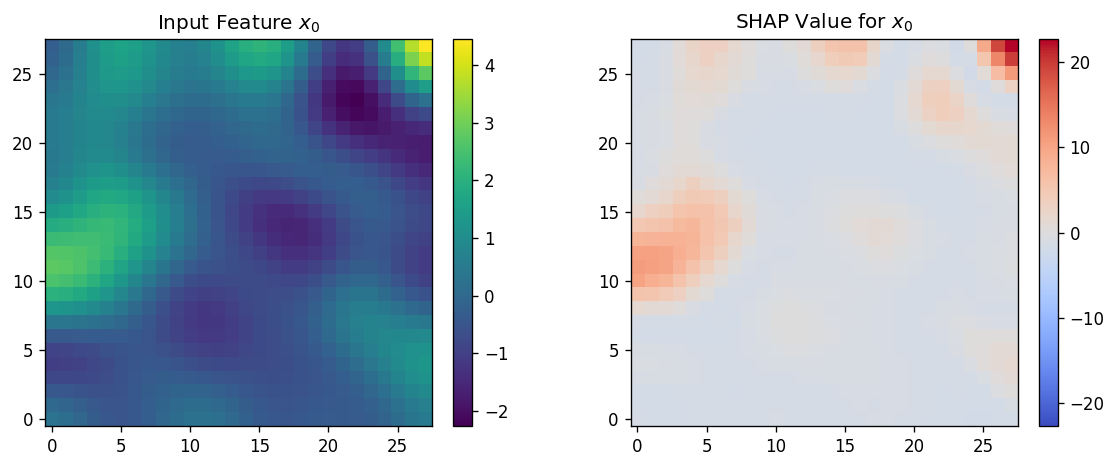

In [9]:
# Generate a multi-channel spatial dataset
# (requires utils.py with make_spatial_mixed in the same folder)
df_mix, meta, X_stack, y_map = make_spatial_mixed(
    ny=28,
    nx=28,
    d=7,
    groups=[[0, 1, 2], [3, 4]],
    rhos=(0.85, 0.75),
    independent_idxs=(5, 6),
    spatial_sigma=3.0,
    target_kind="quad_sin",
    noise_sigma=0.25,
    seed=42,
)

feature_names = [c for c in df_mix.columns if c.startswith("x")]
X_multi = df_mix[feature_names].values
y_multi = df_mix["y"].values

print("X_multi shape:", X_multi.shape)
print("y_multi shape:", y_multi.shape)

# Train a Random Forest on the multi-channel data
model_multi = RandomForestRegressor(n_estimators=100, random_state=42)
model_multi.fit(X_multi, y_multi)

# Explain the model with SHAP
explainer_multi = shap.TreeExplainer(model_multi)
shap_values_multi = explainer_multi(X_multi)

# Visualize SHAP for a single feature channel across space
feat_idx = 0  # try changing this between 0 and 6
shap_map = shap_values_multi[:, feat_idx].values.reshape(28, 28)
input_map = X_stack[:, :, feat_idx]

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

im0 = ax[0].imshow(input_map, origin="lower", cmap="viridis")
ax[0].set_title(f"Input Feature $x_{feat_idx}$")
plt.colorbar(im0, ax=ax[0], fraction=0.046, pad=0.04)

vmax = np.max(np.abs(shap_map))
im1 = ax[1].imshow(shap_map, origin="lower", cmap="coolwarm", vmin=-vmax, vmax=vmax)
ax[1].set_title(f"SHAP Value for $x_{feat_idx}$")
plt.colorbar(im1, ax=ax[1], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

### Interpreting multi-channel SHAP maps

Each pixel in this dataset has 7 feature channels. The left image shows the
raw values of **feature $x_0$** across the entire 28×28 grid.  
The right image shows the **SHAP values for $x_0$** at the same locations—how
much this feature pushes the model prediction up or down at each pixel.

A few key points:

- **Bright red SHAP regions** indicate places where $x_0$ strongly increases
  the prediction.
- **Blue regions** indicate locations where $x_0$ pushes the prediction down.
- Areas where the SHAP map is near zero indicate locations where this feature
  has little influence.

Notice that:

- The SHAP map does **not** simply copy the input feature map.  
  It reflects how the model *uses* that feature in context.
- Some regions where $x_0$ has high values may still have low SHAP influence
  if the model learned that other features explain those areas better.
- Correlated feature groups (e.g., features $([0,1,2])$ often share credit with
  each other—SHAP distributes influence across the correlated channels.

This is exactly what happens in real multi-channel scientific data: even if a
feature looks visually strong, its **predictive contribution** can vary spatially,
and SHAP provides a pixel-wise explanation of that effect.


## 4. Try it yourself! 🎯

Here are a few small experiments you can try to build intuition:

1. **Change the grid resolution**

   In the data-generation cell, change:

   ```python
   nx, ny = 25, 25
   ```

   to something like `nx, ny = 40, 40` or `nx, ny = 15, 15` and see how the
   spatial patterns and SHAP maps change.

2. **Change the noise level**

   In the same cell, modify:

   ```python
   noise = 0.15 * np.random.randn()
   ```

   Try smaller noise (e.g. `0.05`) or larger noise (e.g. `0.5`) and check
   how stable the SHAP maps look.

3. **Change the model complexity**

   In the Random Forest cell, experiment with:

   ```python
   rf = RandomForestRegressor(
       n_estimators=300,
       max_depth=None,
       random_state=0,
       n_jobs=-1,
   )
   ```

   For example, set `max_depth=3` or `max_depth=5` and see whether the spatial
   SHAP maps become smoother or more blocky.

4. **Change the underlying pattern**

   Replace the target definition:

   ```python
   bump = 2.0 * np.exp(-0.5 * (x**2 + y**2))
   sinus = 0.5 * np.sin(2.0 * x)
   ```

   with your own combination (e.g., depend on `y`, or use `np.cos` instead of
   `np.sin`) and see whether SHAP correctly highlights the new pattern.

5. Visualize different feature channels

    Change:
    ```python
    feat_idx = 0
    ```
    to any value 0–6.

    Some channels belong to correlated groups and will share SHAP influence.
    Others may be independent and have near-zero SHAP everywhere.

---

This spatial example forms a bridge between simple tabular tutorials and more
complex scientific workflows with many features and models, which we explore in
**Part 4**.
